# Lesion classification

In [1]:
import sys 
import os
sys.path.append(os.path.abspath("/net/people/plgamyshenin/masters-thesis---melanoma-analysis-with-fnn/experiment--2"))

In [2]:
import numpy as np
import tensorflow as tf
import tensorflow_addons as tfa
import matplotlib.pyplot as plt
from IPython.display import Image, display

from libs.isic import load
from libs.fractal_percolation_module import FractalModule
from libs.auc import calculate_auc
from libs.gradcam import display_gradcam, make_gradcam_heatmap, get_img_array

In [3]:
tf.get_logger().setLevel('ERROR')

## Hyperparameter definition

In [4]:
strategy = tf.distribute.MirroredStrategy()

In [5]:
with strategy.scope():
    EPOCHS = 200
    SAMPLE_NUMBER = None
    
    TARGET_WIDTH, TARGET_HEIGHT = 299, 299
    FRACTAL_WIDTH, FRACTAL_HEIGHT = 5, 5
    FRACTAL_MODULE = FractalModule(FRACTAL_WIDTH, FRACTAL_HEIGHT)
    O_MODEL = tf.keras.applications.inception_resnet_v2.InceptionResNetV2(
        include_top=False,
        weights='imagenet',
        input_shape=(TARGET_WIDTH, TARGET_HEIGHT, 3),
        pooling='avg'
    )
    F_MODEL = tf.keras.applications.inception_resnet_v2.InceptionResNetV2(
        include_top=False,
        weights='imagenet',
        input_shape=(TARGET_WIDTH, TARGET_HEIGHT, 3),
        pooling='avg'
    )
    RETRAINABLE_LAYERS = ['conv2d_202', 'block8_10_conv', 'conv_7b']
    PREPROCESSING = tf.keras.applications.inception_resnet_v2.preprocess_input

## Load the ISIC Archive dataset

In [6]:
(training_set, validation_set, testing_set), class_weights, class_number = load(SAMPLE_NUMBER)

/net/people/plgamyshenin/masters-thesis---melanoma-analysis-with-fnn/experiment--2/libs/isic/load.py:8: DtypeWarning: Columns (3,11,12,14,15,17,18,19) have mixed types. Specify dtype option on import or set low_memory=False.
  metadata = pd.read_csv(f"{os.environ['SCRATCH']}/isic-archive/metadata.csv")


Found 30286 validated image filenames belonging to 10 classes.
Found 7571 validated image filenames belonging to 10 classes.
Found 4207 validated image filenames belonging to 10 classes.


## Model definition

In [7]:
class LesionClassifier(tf.keras.Model):
    def __init__(self):
        super(LesionClassifier, self).__init__()
        
        self.fractal_module = FRACTAL_MODULE
        
        self.resize = tf.keras.layers.Resizing(
            width=TARGET_WIDTH,
            height=TARGET_HEIGHT
        )
        
        self.rescale = tf.keras.layers.Rescaling(scale=1. / 255)
        
        self.o_model = O_MODEL
        for layer in self.o_model.layers:
            if layer.name in RETRAINABLE_LAYERS:
                layer.trainable = True
        else:
            layer.trainable = False
            
        self.f_model = F_MODEL
        for layer in self.f_model.layers:
            if layer.name in RETRAINABLE_LAYERS:
                layer.trainable = True
        else:
            layer.trainable = False
            
        self.fusion = tf.keras.layers.Concatenate()
        
        self.dense = tf.keras.layers.Dense(class_number, activation='softmax')
        
    def call(self, inputs):
        f_outputs = self.fractal_module(inputs)
        f_outputs = self.resize(f_outputs)
        f_outputs = self.rescale(f_outputs)
        f_outputs = self.f_model(f_outputs)

        o_outputs = self.rescale(inputs)
        o_outputs = self.o_model(o_outputs)

        outputs = self.fusion([f_outputs, o_outputs])
        outputs = self.dense(outputs)

        return outputs

In [8]:
checkpoint_path = 'checkpoint'

checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    checkpoint_path,
    monitor='val_loss',
    save_best_only=True,
    save_weights_only=False,
    save_freq='epoch',
    mode='auto'
)

In [9]:
early_stop_callback = tf.keras.callbacks.EarlyStopping(
    monitor="val_loss", 
    min_delta=0.01, 
    patience=15, 
    restore_best_weights=True
)

In [10]:
time_stopping = tfa.callbacks.TimeStopping(seconds=65 * 3600)

## Training

In [11]:
with strategy.scope():
    model = LesionClassifier()
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [12]:
model.fit(
    training_set, 
    validation_data=validation_set, 
    epochs=EPOCHS,
    callbacks=[
        checkpoint_callback,
        early_stop_callback,
        time_stopping
    ]
)

Epoch 1/200
947/947 [==============================] - ETA: 0s - loss: 0.8326 - accuracy: 0.7245

947/947 [==============================] - 3639s 4s/step - loss: 0.8326 - accuracy: 0.7245 - val_loss: 0.7531 - val_accuracy: 0.7546
Epoch 2/200
947/947 [==============================] - ETA: 0s - loss: 0.7092 - accuracy: 0.7546

947/947 [==============================] - 3292s 3s/step - loss: 0.7092 - accuracy: 0.7546 - val_loss: 0.6892 - val_accuracy: 0.7698
Epoch 3/200
947/947 [==============================] - 3042s 3s/step - loss: 0.6579 - accuracy: 0.7706 - val_loss: 0.7801 - val_accuracy: 0.7703
Epoch 4/200
947/947 [==============================] - ETA: 0s - loss: 0.6240 - accuracy: 0.7812

947/947 [==============================] - 3287s 3s/step - loss: 0.6240 - accuracy: 0.7812 - val_loss: 0.5929 - val_accuracy: 0.7904
Epoch 5/200
947/947 [==============================] - 3032s 3s/step - loss: 0.5935 - accuracy: 0.7918 - val_loss: 3.9549 - val_accuracy: 0.6222
Epoch 6/200
947/947 [==============================] - 3005s 3s/step - loss: 0.5683 - accuracy: 0.7994 - val_loss: 0.6027 - val_accuracy: 0.7867
Epoch 7/200
947/947 [==============================] - ETA: 0s - loss: 0.5551 - accuracy: 0.8023

947/947 [==============================] - 3357s 4s/step - loss: 0.5551 - accuracy: 0.8023 - val_loss: 0.5805 - val_accuracy: 0.7940
Epoch 8/200
947/947 [==============================] - 2994s 3s/step - loss: 0.5321 - accuracy: 0.8119 - val_loss: 0.5825 - val_accuracy: 0.7971
Epoch 9/200
947/947 [==============================] - 2989s 3s/step - loss: 0.5124 - accuracy: 0.8187 - val_loss: 0.6158 - val_accuracy: 0.7928
Epoch 10/200
947/947 [==============================] - ETA: 0s - loss: 0.4963 - accuracy: 0.8224

947/947 [==============================] - 3284s 3s/step - loss: 0.4963 - accuracy: 0.8224 - val_loss: 0.5396 - val_accuracy: 0.8115
Epoch 11/200
947/947 [==============================] - ETA: 0s - loss: 0.4759 - accuracy: 0.8288

947/947 [==============================] - 3268s 3s/step - loss: 0.4759 - accuracy: 0.8288 - val_loss: 0.5153 - val_accuracy: 0.8114
Epoch 12/200
947/947 [==============================] - 2988s 3s/step - loss: 0.4693 - accuracy: 0.8322 - val_loss: 0.5223 - val_accuracy: 0.8176
Epoch 13/200
947/947 [==============================] - 3136s 3s/step - loss: 0.4526 - accuracy: 0.8360 - val_loss: 0.5182 - val_accuracy: 0.8109
Epoch 14/200
947/947 [==============================] - ETA: 0s - loss: 0.4454 - accuracy: 0.8401

947/947 [==============================] - 3359s 4s/step - loss: 0.4454 - accuracy: 0.8401 - val_loss: 0.4850 - val_accuracy: 0.8241
Epoch 15/200
947/947 [==============================] - 3050s 3s/step - loss: 0.4269 - accuracy: 0.8462 - val_loss: 0.5026 - val_accuracy: 0.8198
Epoch 16/200
947/947 [==============================] - 3043s 3s/step - loss: 0.4096 - accuracy: 0.8518 - val_loss: 0.5045 - val_accuracy: 0.8229
Epoch 17/200
947/947 [==============================] - 3026s 3s/step - loss: 0.3980 - accuracy: 0.8566 - val_loss: 0.4954 - val_accuracy: 0.8255
Epoch 18/200
947/947 [==============================] - 3056s 3s/step - loss: 0.3830 - accuracy: 0.8618 - val_loss: 0.4898 - val_accuracy: 0.8297
Epoch 19/200
947/947 [==============================] - 3017s 3s/step - loss: 0.3704 - accuracy: 0.8661 - val_loss: 0.5208 - val_accuracy: 0.8268
Epoch 20/200
947/947 [==============================] - ETA: 0s - loss: 0.3653 - accuracy: 0.8689

947/947 [==============================] - 3469s 4s/step - loss: 0.3653 - accuracy: 0.8689 - val_loss: 0.4845 - val_accuracy: 0.8210
Epoch 21/200
947/947 [==============================] - ETA: 0s - loss: 0.3472 - accuracy: 0.8740

947/947 [==============================] - 3243s 3s/step - loss: 0.3472 - accuracy: 0.8740 - val_loss: 0.4738 - val_accuracy: 0.8276
Epoch 22/200
947/947 [==============================] - 2991s 3s/step - loss: 0.3327 - accuracy: 0.8788 - val_loss: 0.4769 - val_accuracy: 0.8321
Epoch 23/200
947/947 [==============================] - 3154s 3s/step - loss: 0.3242 - accuracy: 0.8830 - val_loss: 0.5103 - val_accuracy: 0.8328
Epoch 24/200
947/947 [==============================] - 3335s 4s/step - loss: 0.3161 - accuracy: 0.8847 - val_loss: 0.6182 - val_accuracy: 0.7893
Epoch 25/200
947/947 [==============================] - 3113s 3s/step - loss: 0.3068 - accuracy: 0.8884 - val_loss: 0.4905 - val_accuracy: 0.8353
Epoch 26/200
947/947 [==============================] - ETA: 0s - loss: 0.2853 - accuracy: 0.8954

947/947 [==============================] - 3268s 3s/step - loss: 0.2853 - accuracy: 0.8954 - val_loss: 0.4621 - val_accuracy: 0.8382
Epoch 27/200
947/947 [==============================] - ETA: 0s - loss: 0.2786 - accuracy: 0.8979

947/947 [==============================] - 3395s 4s/step - loss: 0.2786 - accuracy: 0.8979 - val_loss: 0.4613 - val_accuracy: 0.8395
Epoch 28/200
947/947 [==============================] - ETA: 0s - loss: 0.2635 - accuracy: 0.9032

947/947 [==============================] - 3371s 4s/step - loss: 0.2635 - accuracy: 0.9032 - val_loss: 0.4551 - val_accuracy: 0.8514
Epoch 29/200
947/947 [==============================] - 3172s 3s/step - loss: 0.2672 - accuracy: 0.9041 - val_loss: 0.5009 - val_accuracy: 0.8416
Epoch 30/200
947/947 [==============================] - 3022s 3s/step - loss: 0.2576 - accuracy: 0.9071 - val_loss: 0.6431 - val_accuracy: 0.8349
Epoch 31/200
947/947 [==============================] - 3081s 3s/step - loss: 0.2408 - accuracy: 0.9125 - val_loss: 0.4584 - val_accuracy: 0.8492
Epoch 32/200
947/947 [==============================] - 3208s 3s/step - loss: 0.2317 - accuracy: 0.9158 - val_loss: 0.4614 - val_accuracy: 0.8515
Epoch 33/200
947/947 [==============================] - 3068s 3s/step - loss: 0.2213 - accuracy: 0.9180 - val_loss: 0.4588 - val_accuracy: 0.8530
Epoch 34/200
947/947 [==============================] - 3067s 3s/step - loss: 0.2049 - accuracy: 0.9248 - val_loss: 0.7384 - val_accuracy

947/947 [==============================] - 3341s 4s/step - loss: 0.1950 - accuracy: 0.9301 - val_loss: 0.4509 - val_accuracy: 0.8621
Epoch 39/200
947/947 [==============================] - 3045s 3s/step - loss: 0.1748 - accuracy: 0.9355 - val_loss: 0.4629 - val_accuracy: 0.8621
Epoch 40/200
947/947 [==============================] - 3031s 3s/step - loss: 0.1674 - accuracy: 0.9396 - val_loss: 0.4866 - val_accuracy: 0.8504
Epoch 41/200
947/947 [==============================] - 3555s 4s/step - loss: 0.1601 - accuracy: 0.9401 - val_loss: 0.5150 - val_accuracy: 0.8419
Epoch 42/200
947/947 [==============================] - 3033s 3s/step - loss: 0.1570 - accuracy: 0.9438 - val_loss: 0.5534 - val_accuracy: 0.8513
Epoch 43/200
947/947 [==============================] - 3009s 3s/step - loss: 0.1588 - accuracy: 0.9427 - val_loss: 0.5257 - val_accuracy: 0.8589
Epoch 44/200
947/947 [==============================] - 3122s 3s/step - loss: 0.1430 - accuracy: 0.9478 - val_loss: 0.5162 - val_accuracy

## Testing

In [13]:
model.load_weights(checkpoint_path)

In [14]:
groundtruth_labels = np.concatenate([testing_set[i][1] for i in range(len(testing_set))], axis=0)

In [15]:
predicted_labels = model.predict(testing_set)

132/132 [==============================] - 309s 2s/step


In [16]:
fpr, tpr, auc_metric = calculate_auc(testing_set, groundtruth_labels, predicted_labels)

In [17]:
auc_metric

{'actinic keratosis': 0.9815274677760509,
 'basal cell carcinoma': 0.9892427448634755,
 'dermatofibroma': 0.9938839748187107,
 'melanoma': 0.9467832138705561,
 'nevus': 0.9713400102722136,
 'pigmented benign keratosis': 0.9926710440917405,
 'seborrheic keratosis': 0.9654291299645079,
 'solar lentigo': 0.978126246907669,
 'squamous cell carcinoma': 0.9675026123301985,
 'vascular lesion': 0.9929675671368237}

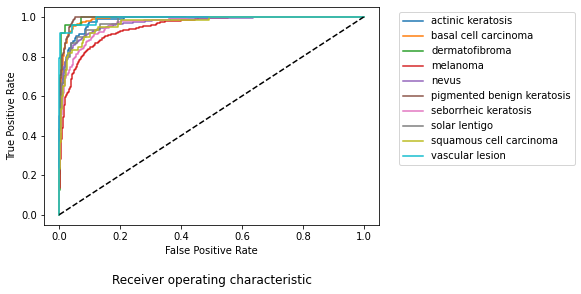

In [18]:
%matplotlib inline 

plt.rcParams['axes.titley'] = -0.3

for diagnosis in testing_set.class_indices:
    plt.plot(fpr[diagnosis], tpr[diagnosis], label=diagnosis)
    
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(bbox_to_anchor=(1.6, 1), loc="upper right")
plt.show()

## GradCam

In [19]:
melanoma_im_path = f"{os.environ['SCRATCH']}/isic-archive/ISIC_0000031.jpg"

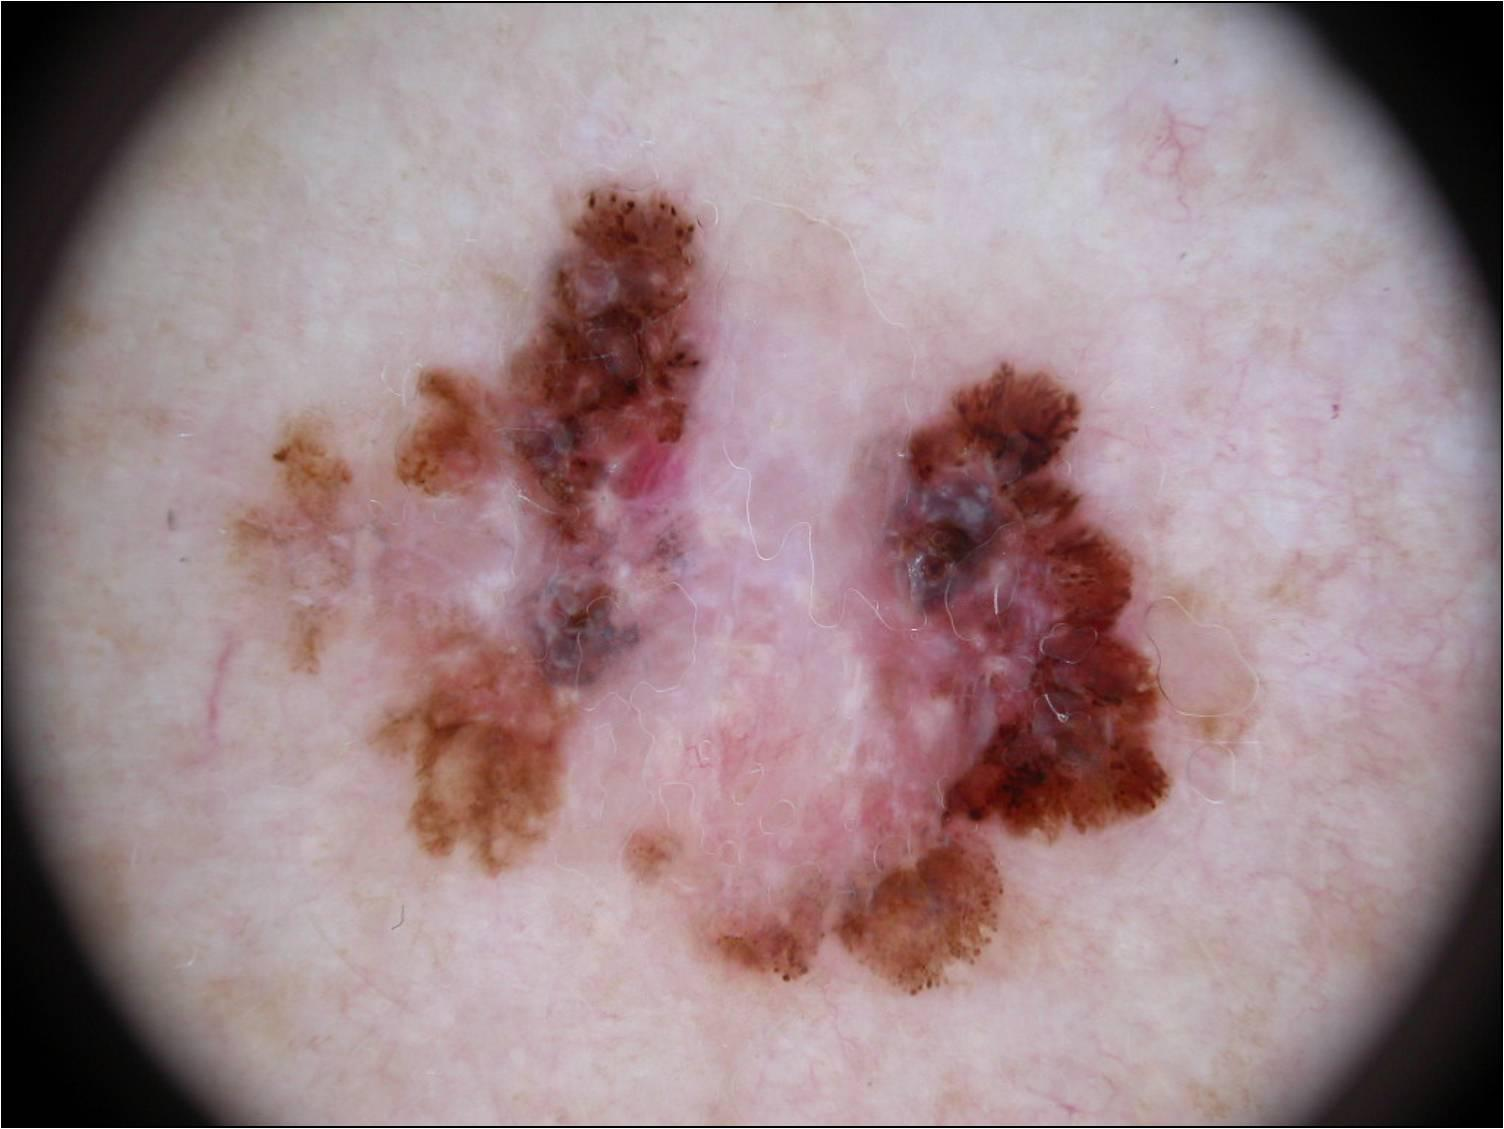

In [20]:
display(Image(melanoma_im_path, width=600))

In [21]:
img_array = PREPROCESSING(get_img_array(melanoma_im_path, size=(299, 299)))

In [22]:
heatmap = make_gradcam_heatmap(img_array, model.o_model, RETRAINABLE_LAYERS[-1])

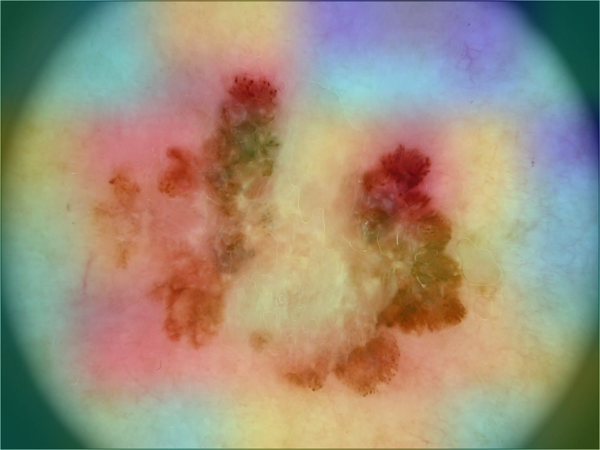

In [23]:
display_gradcam(melanoma_im_path, heatmap)